In [66]:
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as keras_metrics
from tensorflow.python.training.rmsprop import RMSPropOptimizer
import subprocess
import sys
# from keras_video import generator

# from keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import Model

#check I am running on GPUs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6



In [60]:
# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('video-train/*')]
classes.sort()
# some global params
SIZE = (256, 256)
CHANNELS = 1
NBFRAME = 15
BS = 8
# pattern to get videos and classes
glob_pattern='video-train/{classname}/*.mp4'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val = 0.1,
    split_test = 0.1,    
#     split=0.1, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

valid = train.get_validation_generator()

class negative, validation count: 222, test count: 199, train count: 1799
class positive, validation count: 94, test count: 85, train count: 768
Total data: 2 classes for 2567 files for train
Total data: 2 classes for 316 files for validation


In [61]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape, nbout):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [62]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

In [67]:
EPOCHS=20
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)
callbacks = [
    reduce_lr
#     keras.callbacks.ReduceLROnPlateau(verbose=1),
#     keras.callbacks.ModelCheckpoint(
#         'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
#         verbose=1),
]
history = model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
#     callbacks=callbacks
)

Epoch 1/20


Frame count is not OK for video video-train/positive\41c324cf-a33d-11e7-9718-408d5cb3f99b_well03_zid06_scaled.mp4, 6 total, 6 extracted


  2/320 [..............................] - ETA: 2:09:07 - loss: 0.6450 - acc: 0.6667

KeyboardInterrupt: 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


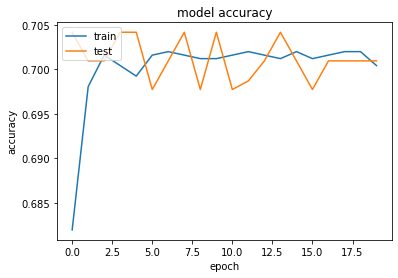

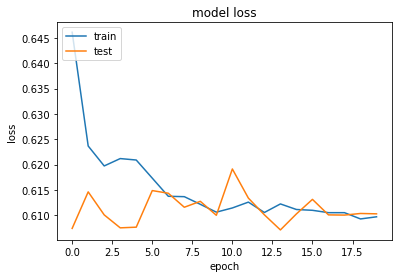

In [65]:
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())

# summarize history for accuracy
fig_name = 'vid_' + str(NBFRAME) + '_con2D' + '_acc.png' 
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig.savefig(fig_name)
plt.show()

# summarize history for loss
fig_name = 'vid_' + str(NBFRAME) + '_con2D' + '_loss.png' 
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig.savefig(fig_name)
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape, nbout):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [2]:
"""
VideoFrameGenerator - Simple Generator
--------------------------------------
A simple frame generator that takes distributed frames from
videos. It is useful for videos that are scaled from frame 0 to end
and that have no noise frames.
"""

import glob
import logging
import os
import re
from math import floor
from typing import Iterable, Optional

import cv2 as cv
import numpy as np
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  img_to_array)
from tensorflow.keras.utils import Sequence

log = logging.getLogger()


class VideoFrameGenerator(Sequence):  # pylint: disable=too-many-instance-attributes
    """
    Create a generator that return batches of frames from video
    - rescale: float fraction to rescale pixel data (commonly 1/255.)
    - nb_frames: int, number of frames to return for each sequence
    - classes: list of str, classes to infer
    - batch_size: int, batch size for each loop
    - use_frame_cache: bool, use frame cache (may take a lot of memory for \
        large dataset)
    - shape: tuple, target size of the frames
    - shuffle: bool, randomize files
    - transformation: ImageDataGenerator with transformations
    - split: float, factor to split files and validation
    - nb_channel: int, 1 or 3, to get grayscaled or RGB images
    - glob_pattern: string, directory path with '{classname}' inside that \
        will be replaced by one of the class list
    - use_header: bool, default to True to use video header to read the \
        frame count if possible
    - seed: int, default to None, keep the seed value for split
    You may use the "classes" property to retrieve the class list afterward.
    The generator has that properties initialized:
    - classes_count: number of classes that the generator manages
    - files_count: number of video that the generator can provides
    - classes: the given class list
    - files: the full file list that the generator will use, this \
        is usefull if you want to remove some files that should not be \
        used by the generator.
    """

    def __init__(  # pylint: disable=too-many-statements,too-many-locals,too-many-branches,too-many-arguments
        self,
        rescale: float = 1 / 255.0,
        nb_frames: int = 5,
        classes: list = None,
        batch_size: int = 16,
        use_frame_cache: bool = False,
        target_shape: tuple = (224, 224),
        shuffle: bool = True,
        transformation: Optional[ImageDataGenerator] = None,
        split_test: float = None,
        split_val: float = None,
        nb_channel: int = 3,
        glob_pattern: str = "./videos/{classname}/*.avi",
        use_headers: bool = True,
        seed=None,
        **kwargs,
    ):

        self.glob_pattern = glob_pattern

        # should be only RGB or Grayscale
        assert nb_channel in (1, 3)

        if classes is None:
            classes = self._discover_classes()

        # we should have classes
        if len(classes) == 0:
            log.warn(
                "You didn't provide classes list or "
                "we were not able to discover them from "
                "your pattern.\n"
                "Please check if the path is OK, and if the glob "
                "pattern is correct.\n"
                "See https://docs.python.org/3/library/glob.html"
            )

        # shape size should be 2
        assert len(target_shape) == 2

        # split factor should be a propoer value
        if split_val is not None:
            assert 0.0 < split_val < 1.0

        if split_test is not None:
            assert 0.0 < split_test < 1.0

        self.use_video_header = use_headers

        # then we don't need None anymore
        split_val = split_val if split_val is not None else 0.0
        split_test = split_test if split_test is not None else 0.0

        # be sure that classes are well ordered
        classes.sort()

        self.rescale = rescale
        self.classes = classes
        self.batch_size = batch_size
        self.nbframe = nb_frames
        self.shuffle = shuffle
        self.target_shape = target_shape
        self.nb_channel = nb_channel
        self.transformation = transformation
        self.use_frame_cache = use_frame_cache

        self._random_trans = []
        self.__frame_cache = {}
        self.files = []
        self.validation = []
        self.test = []

        _validation_data = kwargs.get("_validation_data", None)
        _test_data = kwargs.get("_test_data", None)
        np.random.seed(seed)

        if _validation_data is not None:
            # we only need to set files here
            self.files = _validation_data

        elif _test_data is not None:
            # we only need to set files here
            self.files = _test_data
        else:
            self.__split_from_vals(
                split_val, split_test, classes, shuffle, glob_pattern
            )

        # build indexes
        self.files_count = len(self.files)
        self.indexes = np.arange(self.files_count)
        self.classes_count = len(classes)

        # to initialize transformations and shuffle indices
        if "no_epoch_at_init" not in kwargs:
            self.on_epoch_end()

        kind = "train"
        if _validation_data is not None:
            kind = "validation"
        elif _test_data is not None:
            kind = "test"

        self._current = 0
        self._framecounters = {}
        print(
            "Total data: %d classes for %d files for %s"
            % (self.classes_count, self.files_count, kind)
        )

    def count_frames(self, cap, name, force_no_headers=False):
        """Count number of frame for video
        if it's not possible with headers"""
        if not force_no_headers and name in self._framecounters:
            return self._framecounters[name]

        total = cap.get(cv.CAP_PROP_FRAME_COUNT)

        if force_no_headers or total < 0:
            # headers not ok
            total = 0
            # TODO: we're unable to use CAP_PROP_POS_FRAME here
            # so we open a new capture to not change the
            # pointer position of "cap"
            capture = cv.VideoCapture(name)
            while True:
                grabbed, _ = capture.read()
                if not grabbed:
                    # rewind and stop
                    break
                total += 1

        # keep the result
        self._framecounters[name] = total

        return total

    def __split_from_vals(self, split_val, split_test, classes, shuffle, glob_pattern):
        """ Split validation and test set """

        if split_val == 0 or split_test == 0:
            # no splitting, do the simplest thing
            for cls in classes:
                self.files += glob.glob(glob_pattern.format(classname=cls))
            return

        # else, there is some split to do
        for cls in classes:
            files = glob.glob(glob_pattern.format(classname=cls))
            nbval = 0
            nbtest = 0
            info = []

            # generate validation and test indexes
            indexes = np.arange(len(files))

            if shuffle:
                np.random.shuffle(indexes)

            nbtrain = 0
            if 0.0 < split_val < 1.0:
                nbval = int(split_val * len(files))
                nbtrain = len(files) - nbval

                # get some sample for validation_data
                val = np.random.permutation(indexes)[:nbval]

                # remove validation from train
                indexes = np.array([i for i in indexes if i not in val])
                self.validation += [files[i] for i in val]
                info.append("validation count: %d" % nbval)

            if 0.0 < split_test < 1.0:
                nbtest = int(split_test * nbtrain)
                nbtrain = len(files) - nbval - nbtest

                # get some sample for test_data
                val_test = np.random.permutation(indexes)[:nbtest]

                # remove test from train
                indexes = np.array([i for i in indexes if i not in val_test])
                self.test += [files[i] for i in val_test]
                info.append("test count: %d" % nbtest)

            # and now, make the file list
            self.files += [files[i] for i in indexes]
            print("class %s, %s, train count: %d" % (cls, ", ".join(info), nbtrain))

    def _discover_classes(self):
        pattern = os.path.realpath(self.glob_pattern)
        pattern = re.escape(pattern)
        pattern = pattern.replace("\\{classname\\}", "(.*?)")
        pattern = pattern.replace("\\*", ".*")

        files = glob.glob(self.glob_pattern.replace("{classname}", "*"))
        classes = set()
        for filename in files:
            filename = os.path.realpath(filename)
            classname = re.findall(pattern, filename)[0]
            classes.add(classname)

        return list(classes)

    def next(self):
        """ Return next element"""
        elem = self[self._current]
        self._current += 1
        if self._current == len(self):
            self._current = 0
            self.on_epoch_end()

        return elem

    def get_validation_generator(self):
        """ Return the validation generator if you've provided split factor """
        return self.__class__(
            nb_frames=self.nbframe,
            nb_channel=self.nb_channel,
            target_shape=self.target_shape,
            classes=self.classes,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            rescale=self.rescale,
            glob_pattern=self.glob_pattern,
            use_headers=self.use_video_header,
            _validation_data=self.validation,
        )

    def get_test_generator(self):
        """ Return the validation generator if you've provided split factor """
        return self.__class__(
            nb_frames=self.nbframe,
            nb_channel=self.nb_channel,
            target_shape=self.target_shape,
            classes=self.classes,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            rescale=self.rescale,
            glob_pattern=self.glob_pattern,
            use_headers=self.use_video_header,
            _test_data=self.test,
        )

    def on_epoch_end(self):
        """ Called by Keras after each epoch """

        if self.transformation is not None:
            self._random_trans = []
            for _ in range(self.files_count):
                self._random_trans.append(
                    self.transformation.get_random_transform(self.target_shape)
                )

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return int(np.floor(self.files_count / self.batch_size))

    def __getitem__(self, index):
        classes = self.classes
        shape = self.target_shape
        nbframe = self.nbframe

        labels = []
        images = []

        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        transformation = None

        for i in indexes:

            video = self.files[i]
            classname = self._get_classname(video)

            # create a label array and set 1 to the right column
            label = np.zeros(len(classes))
            col = classes.index(classname)
            label[col] = 1.0

            if video not in self.__frame_cache:
                frames = self._get_frames(
                    video, nbframe, shape, force_no_headers=not self.use_video_header
                )
                if frames is None:
                    # avoid failure, nevermind that video...
                    continue

                # add to cache
                if self.use_frame_cache:
                    self.__frame_cache[video] = frames

            else:
                frames = self.__frame_cache[video]

            # apply transformation
            # if provided
            if self.transformation is not None:
                transformation = self._random_trans[i]
                frames = [
                    self.transformation.apply_transform(frame, transformation)
                    if transformation is not None
                    else frame
                    for frame in frames
                ]

            # add the sequence in batch
            images.append(frames)
            labels.append(label)

        return np.array(images), np.array(labels)

    def _get_classname(self, video: str) -> str:
        """ Find classname from video filename following the pattern """

        # work with real path
        video = os.path.realpath(video)
        pattern = os.path.realpath(self.glob_pattern)

        # remove special regexp chars
        pattern = re.escape(pattern)

        # get back "*" to make it ".*" in regexp
        pattern = pattern.replace("\\*", ".*")

        # use {classname} as a capture
        pattern = pattern.replace("\\{classname\\}", "(.*?)")

        # and find all occurence
        classname = re.findall(pattern, video)[0]
        return classname

    def _get_frames(
        self, video, nbframe, shape, force_no_headers=False
    ) -> Optional[Iterable]:
        cap = cv.VideoCapture(video)
        total_frames = self.count_frames(cap, video, force_no_headers)
        orig_total = total_frames

        if total_frames % 2 != 0:
            total_frames += 1

        frame_step = floor(total_frames / (nbframe - 1))
        # TODO: fix that, a tiny video can have a frame_step that is
        # under 1
        frame_step = max(1, frame_step)
        frames = []
        frame_i = 0

        while True:
            grabbed, frame = cap.read()
            if not grabbed:
                break

            self.__add_and_convert_frame(
                frame, frame_i, frames, orig_total, shape, frame_step
            )

            if len(frames) == nbframe:
                break

        cap.release()

        if not force_no_headers and len(frames) != nbframe:
            # There is a problem here
            # That means that frame count in header is wrong or broken,
            # so we need to force the full read of video to get the right
            # frame counter
            return self._get_frames(video, nbframe, shape, force_no_headers=True)

        if force_no_headers and len(frames) != nbframe:
            # and if we really couldn't find the real frame counter
            # so we return None. Sorry, nothing can be done...
            log.error(
                f"Frame count is not OK for video {video}, "
                f"{total_frames} total, {len(frames)} extracted"
            )
            return None

        return np.array(frames)

    def __add_and_convert_frame(  # pylint: disable=too-many-arguments
        self, frame, frame_i, frames, orig_total, shape, frame_step
    ):
        frame_i += 1
        if frame_i in (1, orig_total) or frame_i % frame_step == 0:
            # resize
            frame = cv.resize(frame, shape)

            # use RGB or Grayscale ?
            frame = (
                cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                if self.nb_channel == 3
                else cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
            )

            # to np
            frame = img_to_array(frame) * self.rescale

            # keep frame
            frames.append(frame)

In [3]:
"""
Utils module to provide some nice functions to develop with Keras and
Video sequences.
"""

import random as rnd
import secrets

import matplotlib.pyplot as plt
import numpy as np


def show_sample(g, index=0, random=False, row_width=22, row_height=5):
    """ Displays a batch using matplotlib.
    params:
    - g: keras video generator
    - index: integer index of batch to see (overriden if random is True)
    - random: boolean, if True, take a random batch from the generator
    - row_width: integer to give the figure height
    - row_height: integer that represents one line of image, it is multiplied by \
    the number of sample in batch.
    """
    total = len(g)
    if random:
        sample = secrets.randbelow(total)
    else:
        sample = index

    assert index < len(g)
    sample = g[sample]
    sequences = sample[0]
    labels = sample[1]

    rows = len(sequences)
    index = 1
    plt.figure(figsize=(row_width, row_height * rows))
    for batchid, sequence in enumerate(sequences):
        classid = np.argmax(labels[batchid])
        classname = g.classes[classid]
        cols = len(sequence)
        for image in sequence:
            plt.subplot(rows, cols, index)
            plt.title(classname)
            plt.imshow(image)
            plt.axis("off")
            index += 1
    plt.show()